In [2]:
%matplotlib widget
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

In [4]:
import sys
sys.path.append('../scripts')

In [5]:
from oct_archive import open_OCTdata 
from oct_features import extract_features

In [6]:
dir_= '/data/astro/scratch/lcabayol/VHIR/data/OCT_2_analysis'

In [7]:
archive = open_OCTdata(dir_, ['RETINA','RETINA1','RETINA2','RETINA3'])

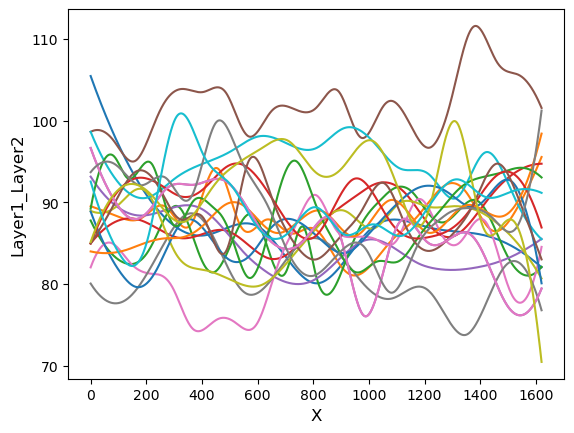

In [8]:
archive._plot_archive('X','Layer1_Layer2')

## PCA

In [8]:
feature_extractor = extract_features(archive)

In [9]:
pca_comp= feature_extractor._pca_features(2,'Layer1_Layer2')

2 PCA components explain 0.7056851983070374 of the variance


Text(0, 0.5, 'PCA 2')

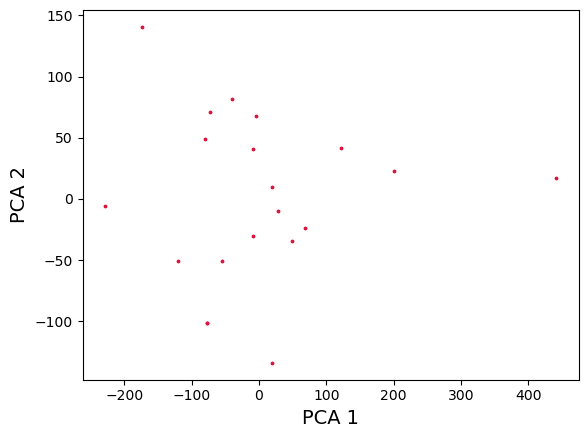

In [10]:
plt.scatter(pca_comp[:,0],pca_comp[:,1], s = 3, color='crimson')
plt.xlabel('PCA 1', fontsize = 14)
plt.ylabel('PCA 2', fontsize = 14)

## AUTOENCODER

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor



class MDNemulator_polyfit(pl.LightningModule):
    def __init__(self,learning_rate,epochs,ncomp, input_size, nhidden=3):
        super().__init__()
        self.automatic_optimization = True
        self.learning_rate = learning_rate
        self.epochs=epochs
        self.ncomp=ncomp
        self.loss = nn.L1Loss()
        
        
        params_encoder = np.linspace(input_size,ncomp,nhidden)
        modules = []
        for k in range(nhidden-1):
            modules.append(nn.Linear(int(params_encoder[k]) ,int(params_encoder[k+1])))
            modules.append(nn.LeakyReLU(0.2))  
        self.encoder = nn.Sequential(*modules)
        
        params_decoder = np.linspace(ncomp,input_size,nhidden)
        modules = []
        for k in range(nhidden-1):
            modules.append(nn.Linear(int(params_decoder[k]) ,int(params_decoder[k+1])))
            modules.append(nn.LeakyReLU(0.2))  
        self.decoder = nn.Sequential(*modules)
        
        
    def forward(self, xinp):
        xlatent = self.encoder(xinp)
        xout = self.decoder(xlatent)

        return xlatent,xout  
    
    def training_step(self, batch, batch_idx):
        xinp = batch
        #print(xinp[0])
        
        xlatent,xout  = self(xinp[0])#.cuda()
        loss = self.loss(xout,xinp[0])

        self.log('train_loss', loss, prog_bar=True)
        
        lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('lr', lr, prog_bar=True, logger=False)
    
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=int(0.75*self.epochs), gamma=0.1)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]


In [51]:
atr = 'Layer1_Layer2'
epochs = 500
ncomp = 2

X_dat = getattr(archive, atr)
input_size = X_dat.shape[1]
learning_rate = 1e-4

trainig_dataset = TensorDataset(torch.Tensor(X_dat))
loader_train = DataLoader(trainig_dataset, batch_size=100, shuffle = True)

autoencoder = MDNemulator_polyfit(learning_rate=learning_rate,epochs=epochs,ncomp=ncomp, input_size=input_size)
trainer = Trainer(max_epochs=epochs,enable_progress_bar=False)

#lr_finder = trainer.tuner.lr_find(model, loader_train, min_lr= 1e-6, max_lr= 1e-2, mode='exponential')
#autoencoder.learning_rate = lr_finder.suggestion()
trainer.fit(autoencoder, train_dataloaders=loader_train)




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | loss    | L1Loss     | 0     
1 | encoder | Sequential | 526 K 
2 | decoder | Sequential | 527 K 
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.219     Total estimated model params size (MB)
/data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-package

In [48]:
X_dat_latent,X_dat_out = autoencoder(torch.Tensor(X_dat))

In [49]:
X_dat.shape,  X_dat_out.detach().cpu().numpy().shape

((20, 1024), (20, 1024))

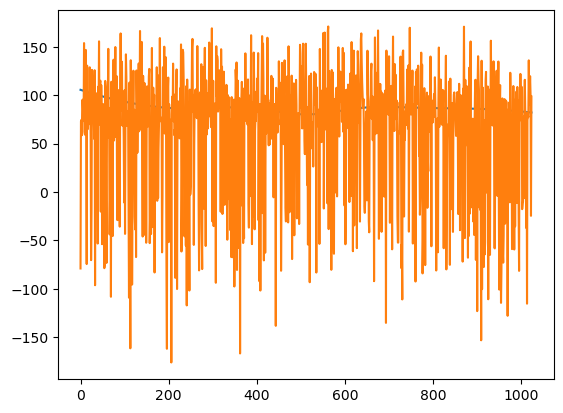

In [50]:
plt.plot(X_dat[0])
plt.plot(X_dat_out.detach().cpu().numpy()[0])

In [ ]:

Nnets = 1
#emu_p1ds_comb = np.zeros(shape=(Nnets,11,32))

for n in range(Nnets):
    idx = np.random.randint(0,len(training_data),4500)
    training_data_sub = training_data[idx]
    training_label_sub = training_label[idx]
    
    trainig_dataset = TensorDataset(training_data_sub,training_label_sub)
    loader_train = DataLoader(trainig_dataset, batch_size=100, shuffle = True)

    model = MDNemulator_polyfit(5,1e-3, torch.log10(training_k),None)
    initial_weights = torch.load('initial_weight_4thorder_v2.pt', map_location='cpu')
    model.load_state_dict(initial_weights)
    trainer = Trainer(auto_lr_find=True, max_epochs=600,enable_progress_bar=False)

    # Use the LR finder to find a good learning rate
    lr_finder = trainer.tuner.lr_find(model, loader_train, min_lr= 1e-6, max_lr= 1e-3, mode='exponential')

    print(lr_finder.suggestion())

    model.learning_rate = lr_finder.suggestion()

    # Train the model with the optimal learning rate
    lr_monitor = LearningRateMonitor(logging_interval='step')
    trainer.fit(model, train_dataloaders=loader_train)

    fractional_error, emu_p1ds, true_p1ds = test_sim(truth, model)
    #emu_p1ds_comb[n] = emu_p1ds

In [12]:
feature_extractor = extract_features(archive)

In [13]:
pca_comp= feature_extractor._LDA_features('Layer1_Layer2')

TypeError: fit() missing 1 required positional argument: 'y'

In [96]:
Layer1_Layer2_data = getattr(archive, 'Layer1_Layer2')

In [103]:
mean_L1L2 = Layer1_Layer2_data.mean(1)
max_L1L2 = Layer1_Layer2_data.max(1)
min_L1L2 = Layer1_Layer2_data.min(1)

In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
L1L1_decom = pca.fit_transform(archive.Layer1_Layer2)
print(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())



[0.5724127  0.13327254] 0.70568526


In [77]:
L1L1_decom

array([[ -54.57312  ,  -50.45195  ,   29.98409  ],
       [  -9.400783 ,  -29.990671 ,  -47.293457 ],
       [ -79.59987  ,   49.087578 ,   21.591364 ],
       [  -4.605886 ,   67.634125 ,  -53.14522  ],
       [-119.948105 ,  -51.094048 ,  -11.329777 ],
       [ 440.95477  ,   17.154457 ,  -32.42485  ],
       [-174.34604  ,  140.6473   ,   23.82178  ],
       [-228.52391  ,   -5.737322 ,  -20.561146 ],
       [ -72.35209  ,   71.1639   ,   13.880746 ],
       [ 200.94351  ,   23.169012 ,   78.80797  ],
       [ -39.79854  ,   81.61814  ,  -31.87818  ],
       [  -8.537394 ,   40.57572  ,  -40.37203  ],
       [  27.778978 ,   -9.539425 ,  -73.589966 ],
       [  68.72964  ,  -23.943115 ,  -12.001427 ],
       [ -77.50325  , -101.43356  ,   64.7136   ],
       [  18.658512 ,    9.556968 ,   -2.8242028],
       [ -77.50324  , -101.433525 ,   64.71356  ],
       [  19.014984 , -134.1359   ,  -43.53998  ],
       [ 121.36546  ,   41.549305 ,  123.07775  ],
       [  49.2464   ,  -34.3968

In [71]:
archive.Layer1_Layer2.shape

(20, 1024)